In [1]:
import os
import sys
import json
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cycler import cycler
from IPython.core.display import HTML

from plot_utils import process_flower_logs, read_fedless_logs

### How to use

Download the latest zip file with all experiment artifacts from `https://fedless-experiment-artifacts.s3.eu-central-1.amazonaws.com/fedless-experiments-1096e15-1628246697.zip`, unzip it, and copy the absolute path to the `out` folder.

### Global Variables and Style Configuration

In [2]:
ROOT_OUT_DIR = Path("/Users/andreas/workspace/thesis-code/out/")
PLOT_OUTPUT_DIR = ROOT_OUT_DIR / "plots"
FLOWER_LOGS_DIR = ROOT_OUT_DIR / "flower-logs"

PLOT_OUTPUT_DIR.mkdir(exist_ok=True)

In [3]:
plt.style.use(['science', 'bright', 'ieee'])

In [4]:
flower_df = process_flower_logs(FLOWER_LOGS_DIR)
fedkeeper_df, fedkeeper_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedkeeper*-*-*-*-*-*-*")
fedless_df, fedless_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-[!d]*-*-*-*-*-*", ignore_dp=True) # [!d] ignores DP experiments
fedless_dp_df, fedless_dp_clients_df = read_fedless_logs(f"{ROOT_OUT_DIR}/fedless-dp-*", ignore_dp=False)

KeyError: 'Only a column name can be used for the key in a dtype mappings argument.'

## FedLess on MNIST and LEAF

In [932]:
df_ = fedless_df.loc[("mnist", slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[("mnist", slice(1, 200), 200), :]
df_ = df_[df_["accuracy"] >= 0.99]
df_ = df_.groupby(["clients-round", "seed"]).min("round").groupby("clients-round").mean()["round"]
df_

clients-round
25     76.000000
100    84.333333
200    78.000000
Name: round, dtype: float64

<Figure size 1980x1500 with 0 Axes>

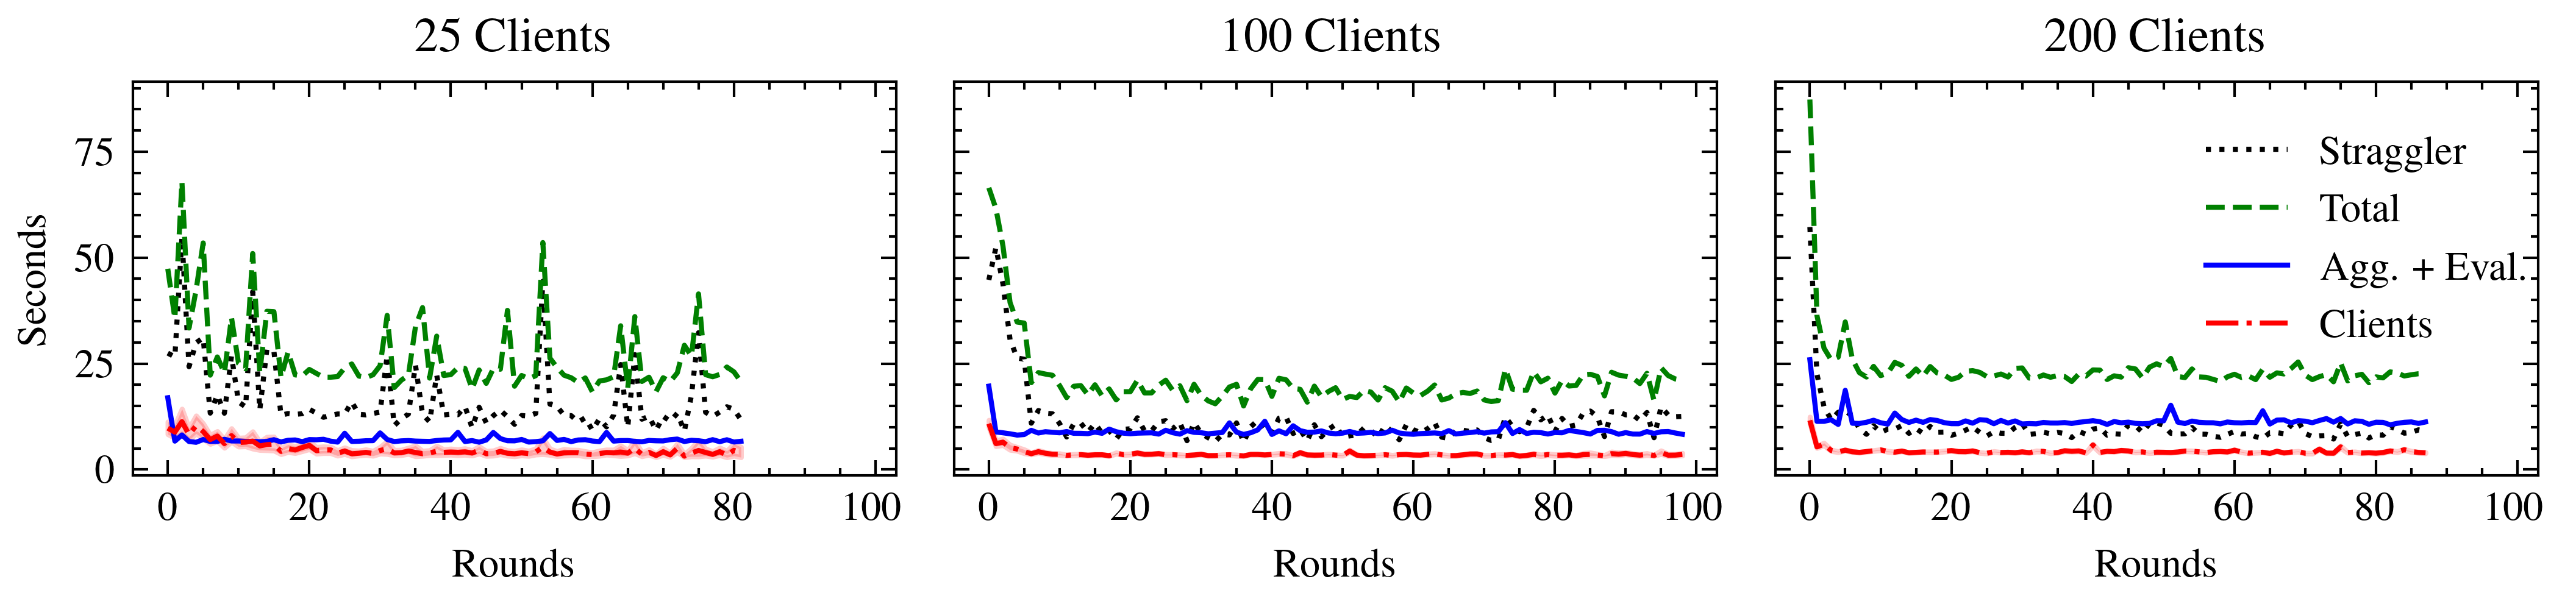

In [642]:
dataset = "mnist"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]
clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]#.reset_index()    
mean_maximum_client_per_round_df = clients_df_.groupby(["clients-round", "seed", "round"]).max("seconds").groupby(["clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["clients-round", "round"]).mean()
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(7.167, 7.167 / 4))
for i, clients in enumerate([25, 100, 200]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[clients],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="time",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Total"
    )
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Agg. + Eval."
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_df_.loc[(dataset, clients)],
        ax=axarr[i],
        label="Clients",
        ci=95
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85, 0.4))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-straggler-impact.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

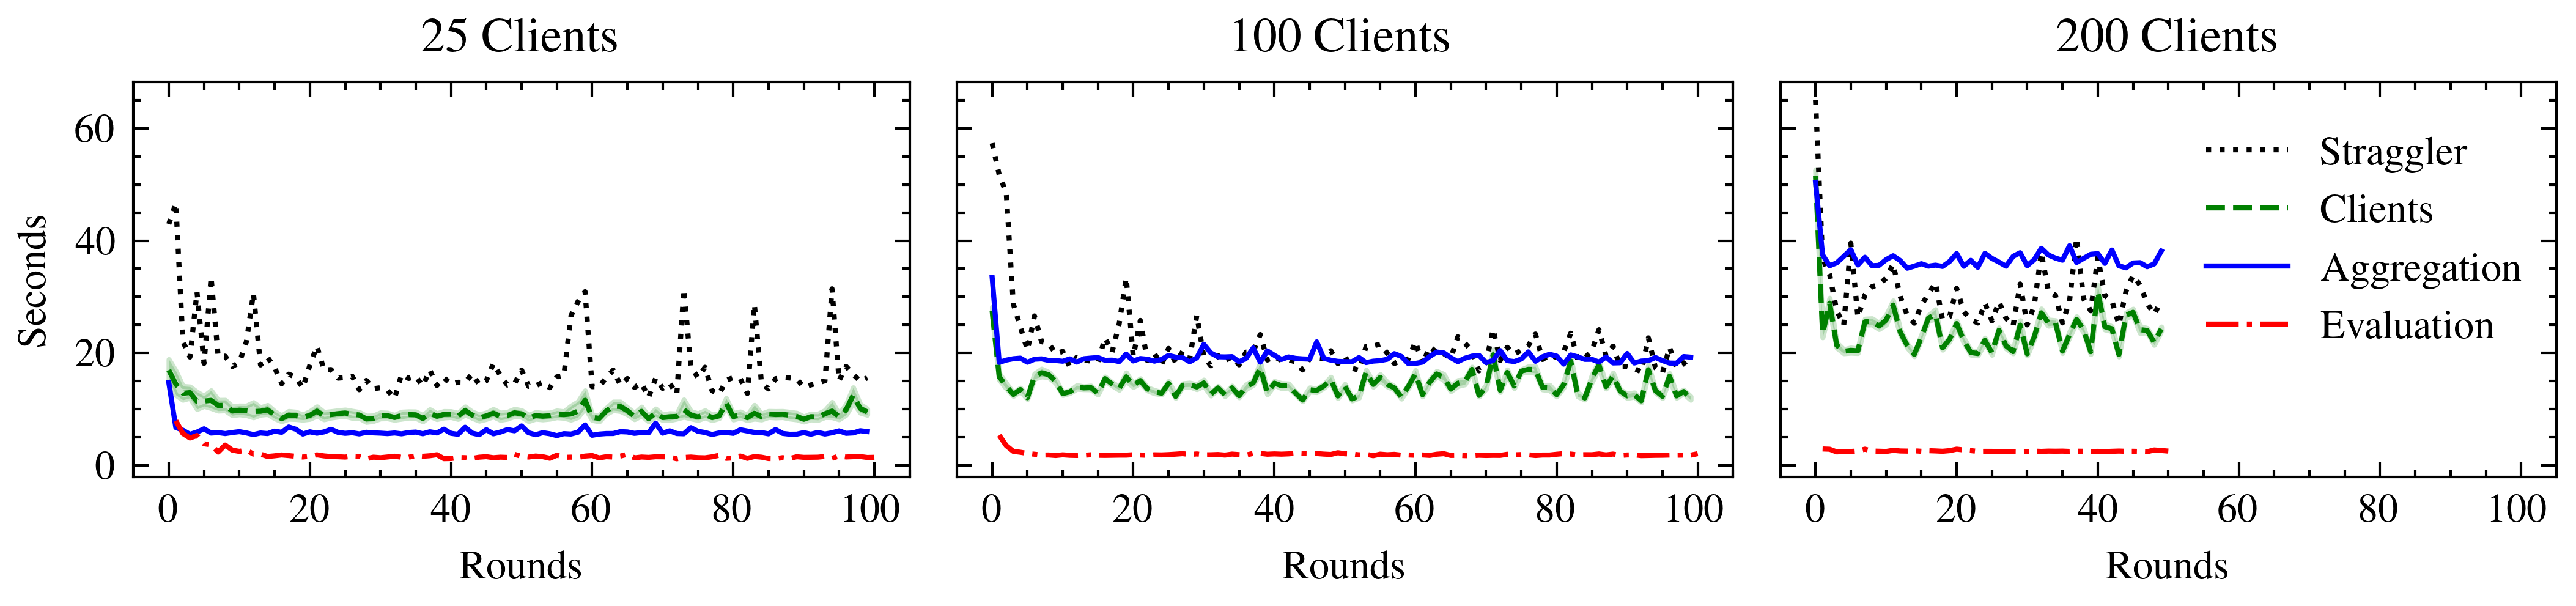

In [661]:
dataset = "femnist"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]
clients_train_df_ = clients_df_[clients_df_["eval"] == False]
mean_maximum_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "seed", "round"]).max("seconds").groupby(["eval", "clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(7.167, 7.167 / 4))
for i, clients in enumerate([25, 100, 200]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_train_df_.loc[(dataset, clients), :], # mean_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Clients",
    )
    #sns.lineplot(
    #    x="round",
    #    y="time",
    #    data=mean_round_df.loc[clients],
    #    ax=axarr[i],
    #    label="Total"
    #)
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Aggregation"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_client_per_round_df.loc[(True, clients), :],
        ax=axarr[i],
        label="Evaluation"
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.85, 0.4))
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-straggler-impact.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

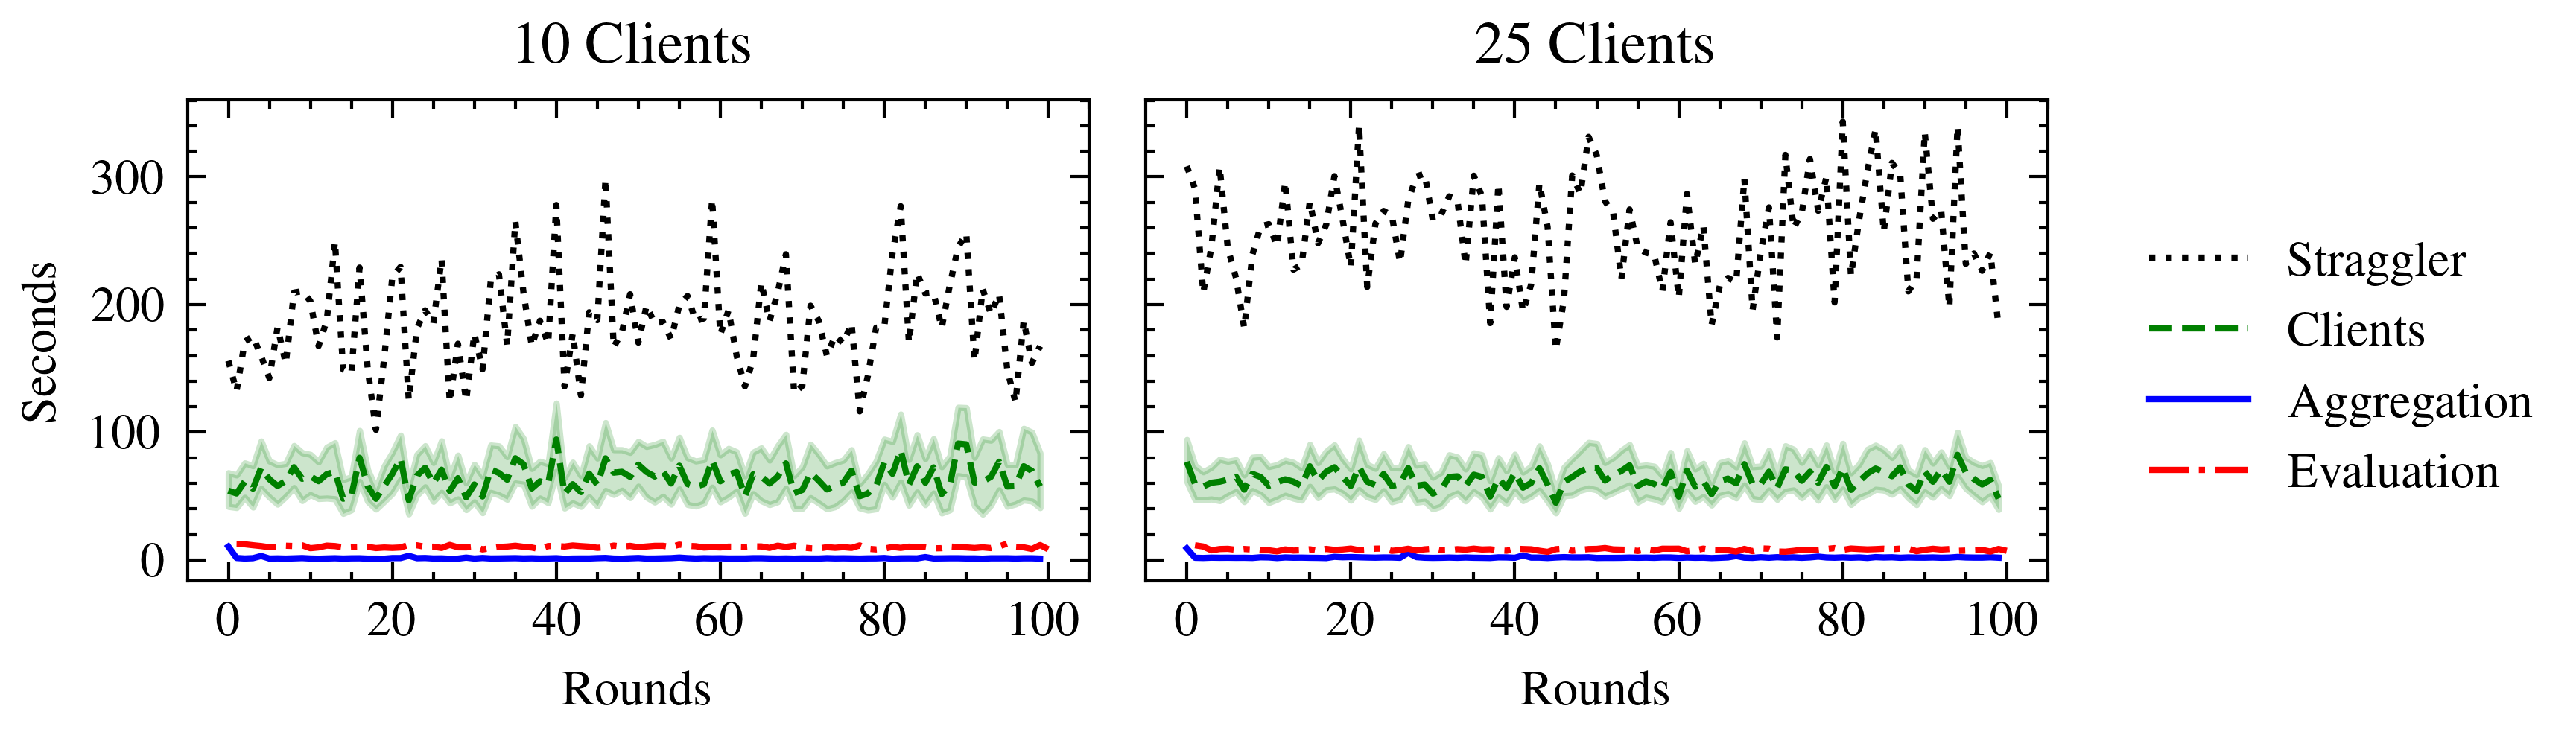

In [662]:
dataset = "shakespeare"
df_ = fedless_df.loc[(dataset, slice(1, 200), 200), :]

clients_df_ = fedless_clients_df.loc[(dataset, slice(1, 200), 200), :]#.reset_index()    
clients_train_df_ = clients_df_[clients_df_["eval"] == False]
mean_maximum_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "seed", "round"]).max("seconds").groupby(["eval", "clients-round", "round"]).mean()
mean_client_per_round_df = clients_df_.groupby(["eval", "clients-round", "round"]).mean()
mean_round_df = df_.groupby(["clients-round", "round"]).mean()

plt.clf()
fig, axarr = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(7.167 / 1.5, 7.167 / 4))
for i, clients in enumerate([10, 25]):
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_maximum_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Straggler"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=clients_train_df_.loc[(dataset, clients), :], # mean_client_per_round_df.loc[(False, clients), :],
        ax=axarr[i],
        label="Clients",
    )
    #sns.lineplot(
    #    x="round",
    #    y="time",
    #    data=mean_round_df.loc[clients],
    #    ax=axarr[i],
    #    label="Total"
    #)
    sns.lineplot(
        x="round",
        y="time-aggregation",
        data=mean_round_df.loc[clients],
        ax=axarr[i],
        label="Aggregation"
    )
    sns.lineplot(
        x="round",
        y="seconds",
        data=mean_client_per_round_df.loc[(True, clients), :],
        ax=axarr[i],
        label="Evaluation"
    )
    axarr[i].set_title(f"{clients} Clients")
    axarr[i].set_xlabel("Rounds")
    axarr[i].set_ylabel("Seconds")
    axarr[i].get_legend().remove()
    
handles, labels = axarr[-1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()

fig.savefig(PLOT_OUTPUT_DIR / f"fedless-{dataset}-straggler-impact.pdf", bbox_inches ='tight',pad_inches=0, bbox_extra_artists=(lgd,))

<Figure size 1980x1500 with 0 Axes>

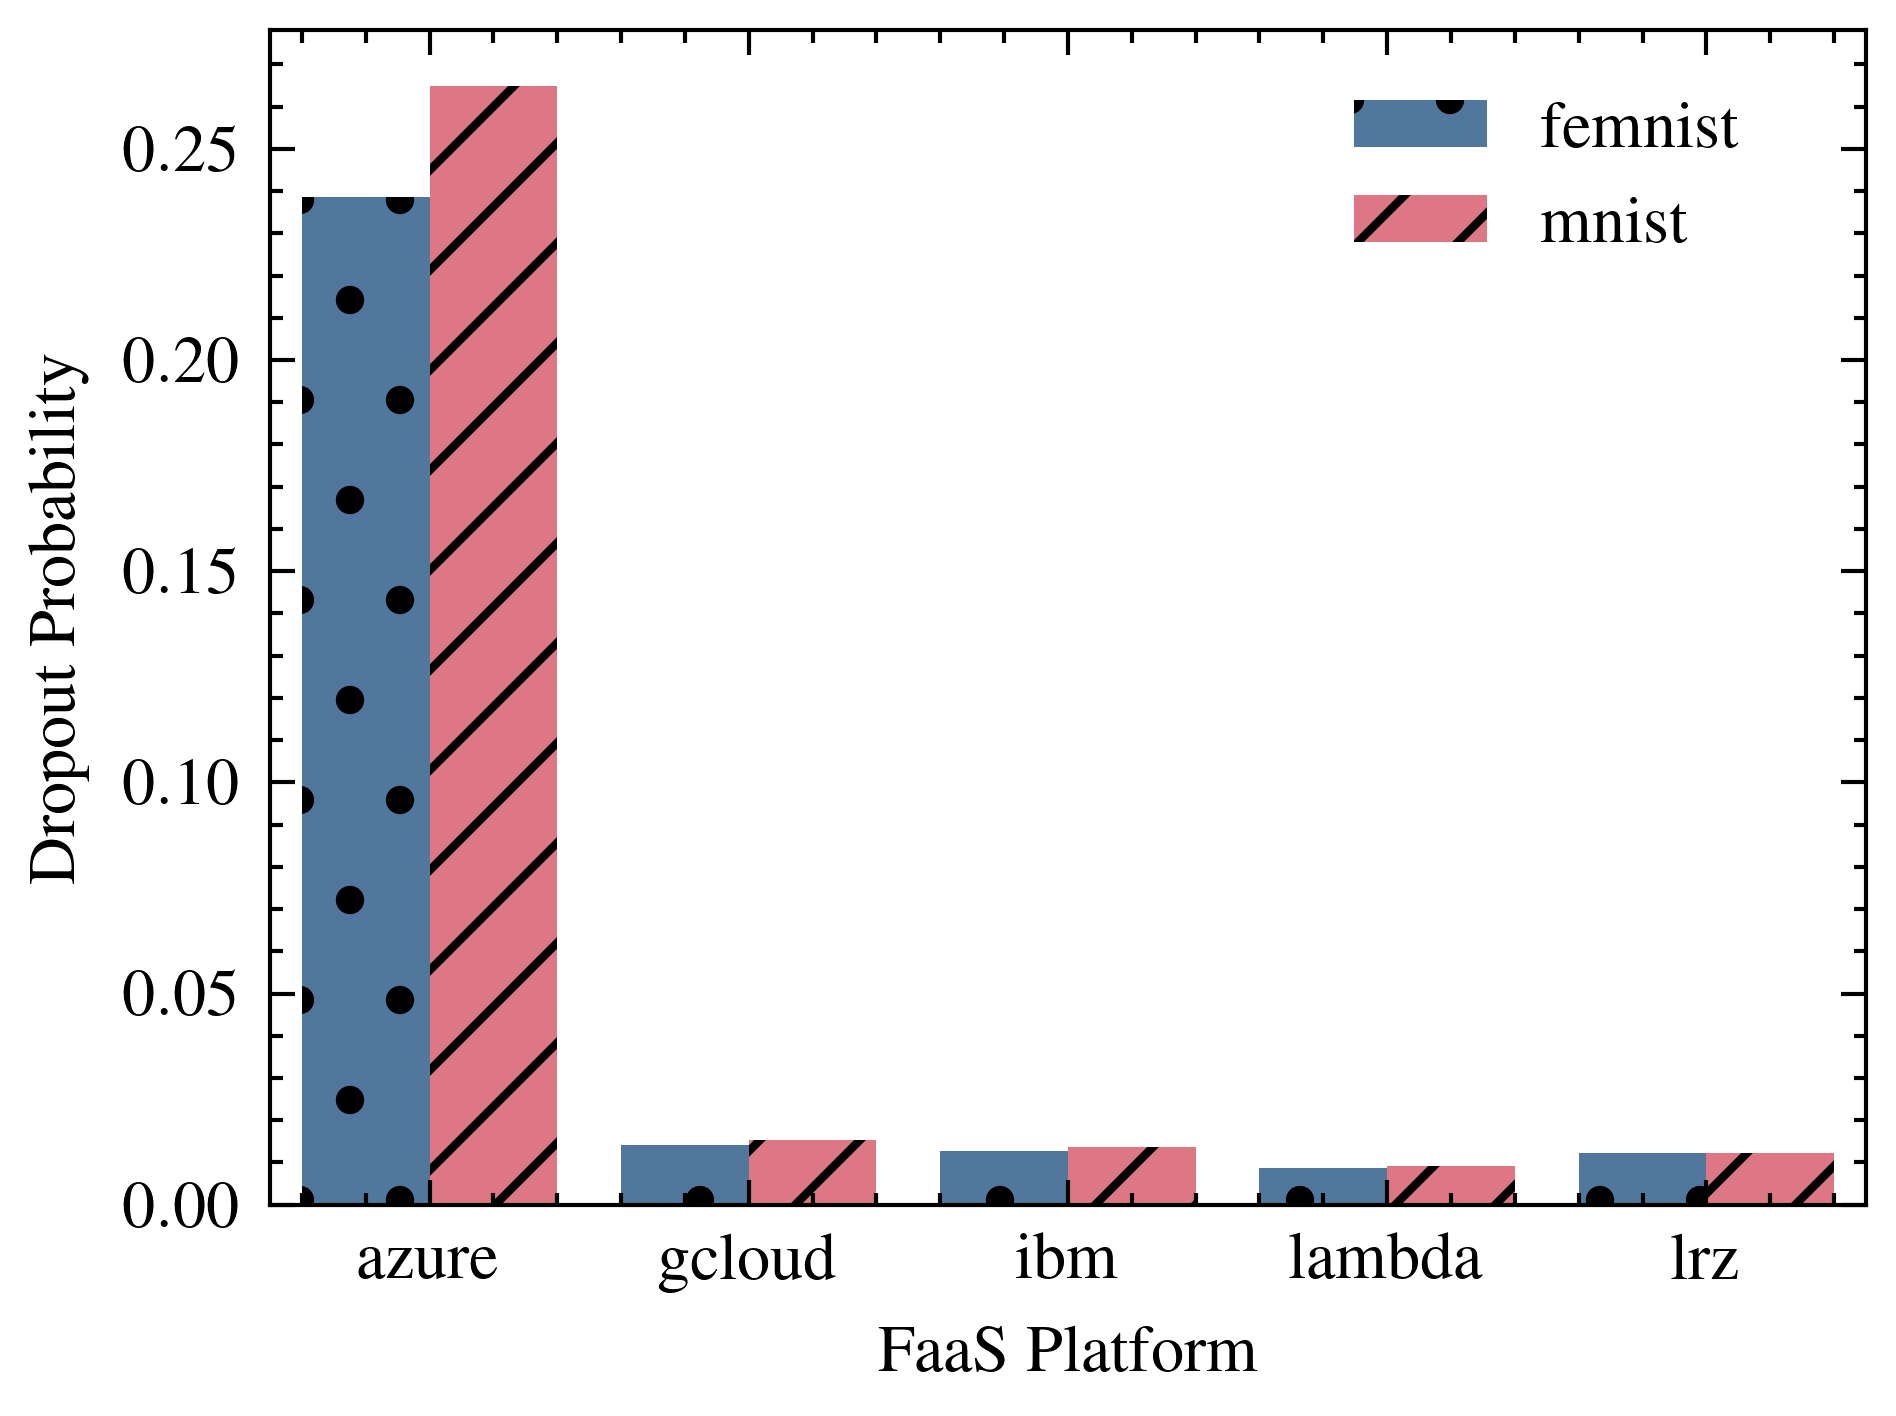

In [648]:
clients_df_ = fedless_clients_df.loc[(("mnist", "femnist"), slice(1, 200), 200), :].reset_index()
clients_df_ = clients_df_[clients_df_["eval"] == False]

df_ = (
    clients_df_.loc[clients_df_.groupby(["dataset", "seed", "round"]).idxmax()["seconds"], :].groupby("platform").size() / 
    clients_df_.groupby(["dataset", "platform"]).size()
).reset_index()
plt.clf()
with plt.style.context(['science', 'ieee', 'bright']):
    fig, ax = plt.subplots()
    sns.barplot(
        y=0,
        x="platform",
        hue="dataset",
        data=df_,
        ax=ax,
        #linewidth=1, 
        #facecolor=(1, 1, 1, 0),
        #errcolor=".2", 
        #edgecolor=".2"
    )

    num_locations = len(df_.platform.unique())
    hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

    ax.set_xlabel("FaaS Platform")
    ax.set_ylabel("Dropout Probability")
    ax.get_legend().remove()
    fig.legend(loc=(0.7, 0.8))
    fig.tight_layout()
    fig.savefig(PLOT_OUTPUT_DIR / f"fedless-platforms-dropout-prob.pdf", bbox_inches ='tight',pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

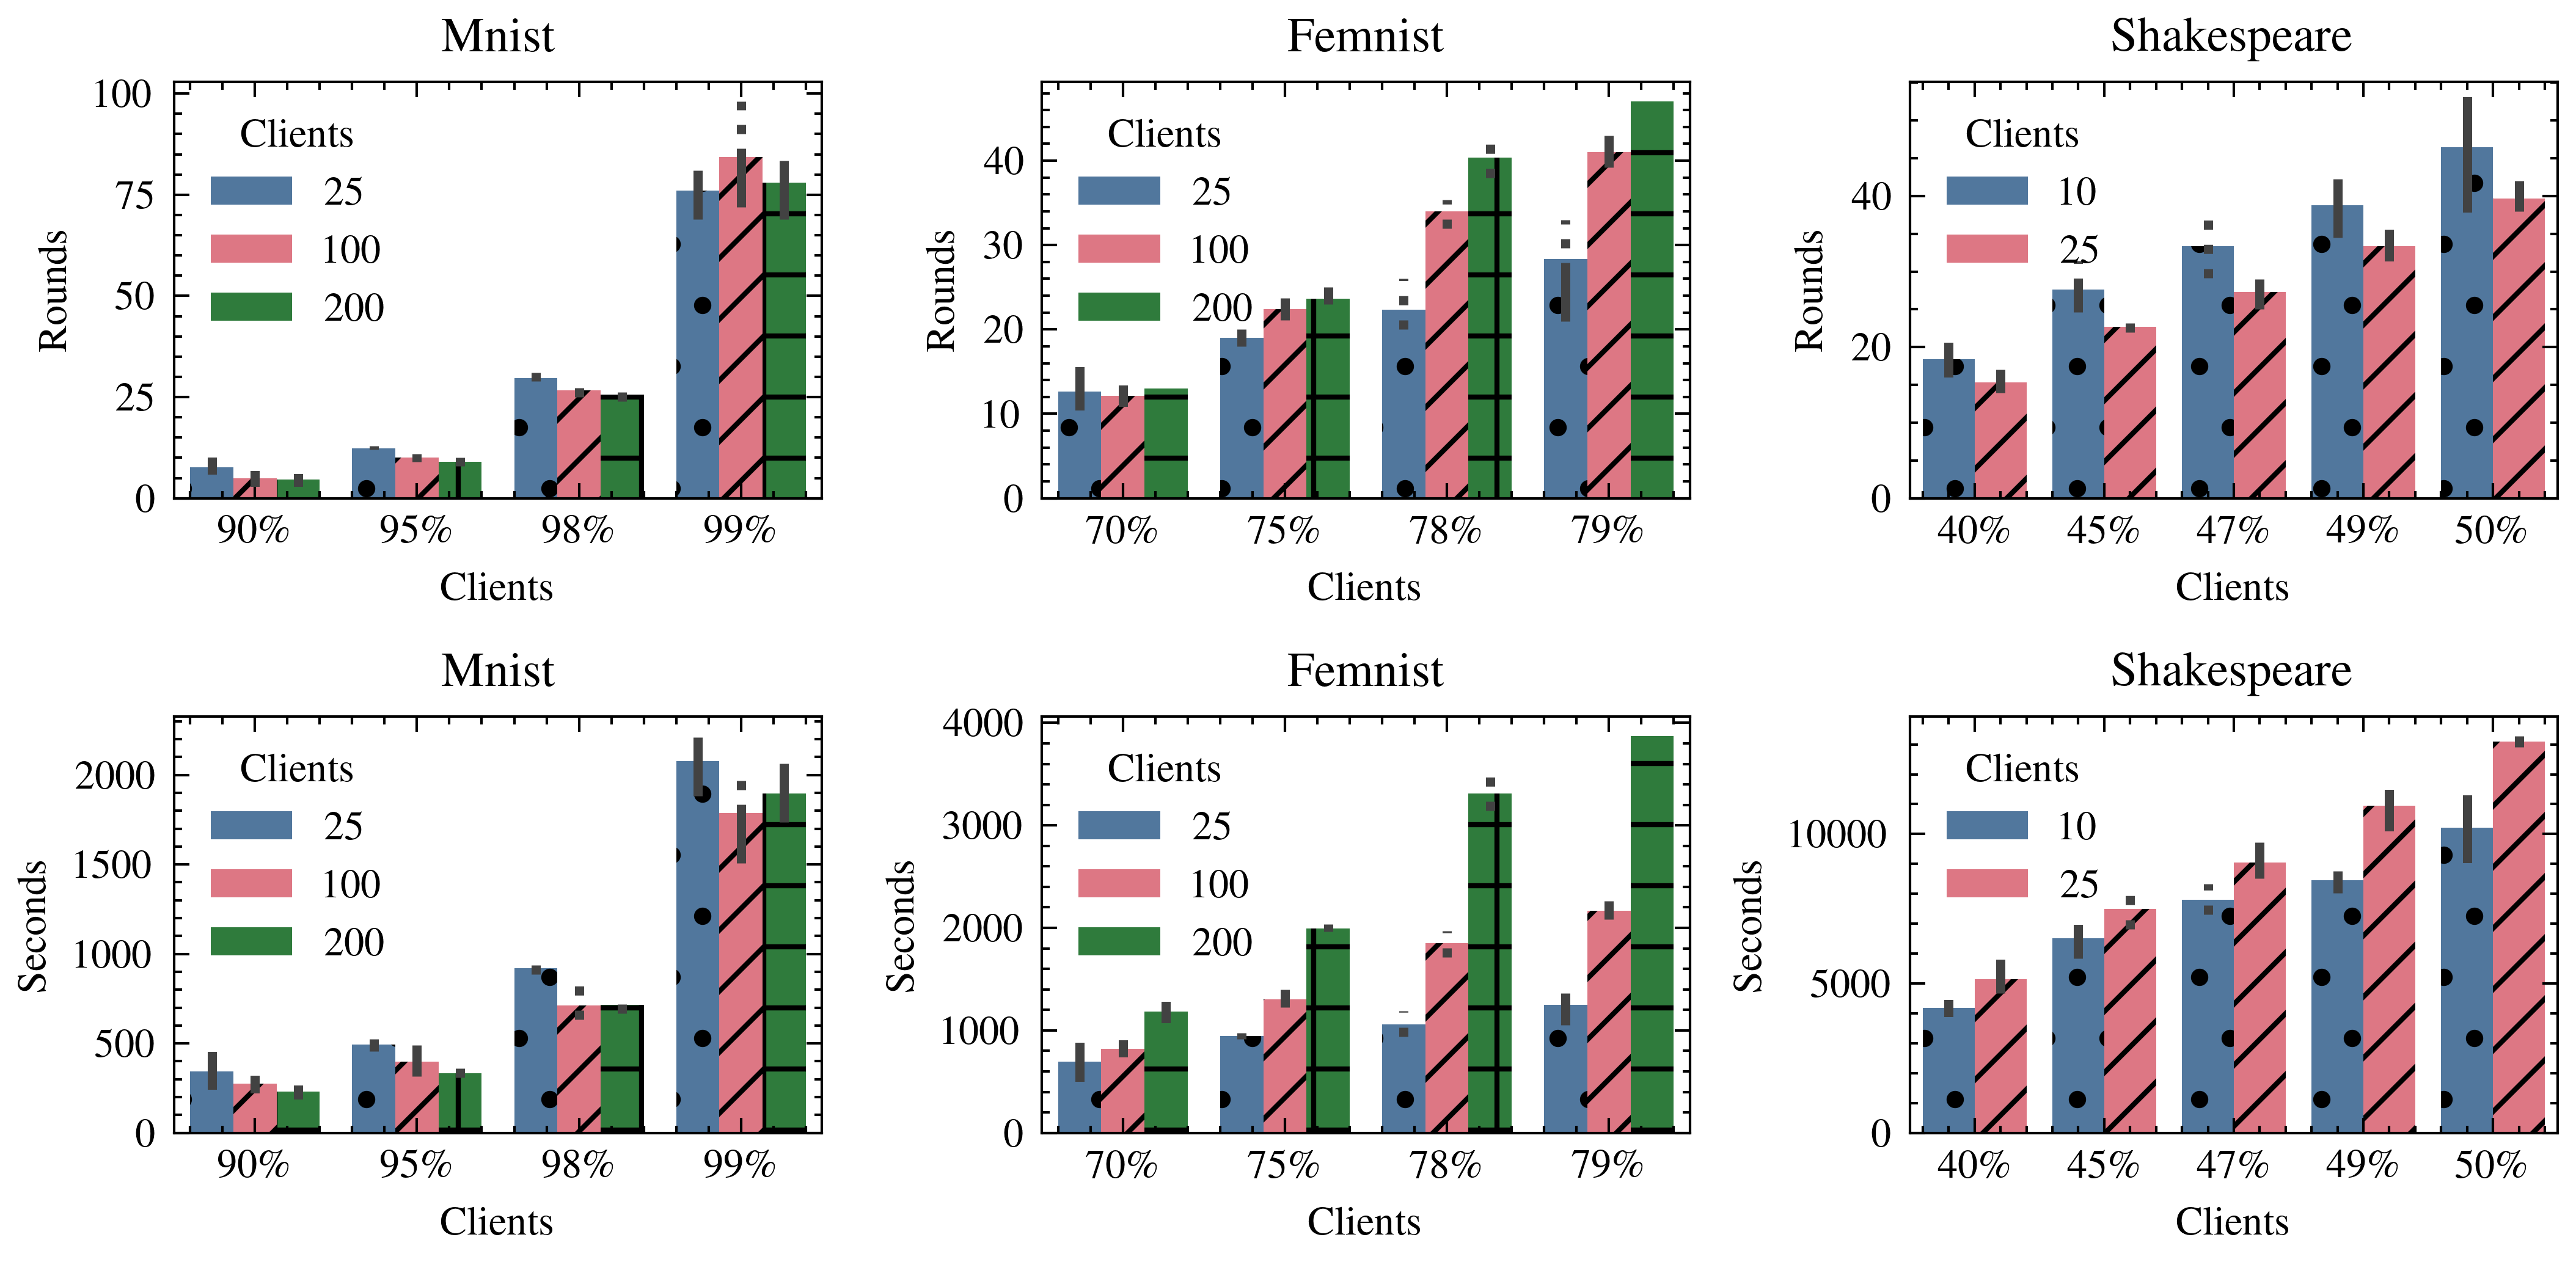

In [1065]:
plt.clf()
fig, axarr = plt.subplots(nrows=2, ncols=3, sharex="col", figsize=(7.167, 7.167 / 2))

fedless_df_ = fedless_df.copy()
fedless_df_['time-total'] = fedless_df_.groupby(["dataset", "clients-round", "seed"])['time'].transform(pd.Series.cumsum)

with plt.style.context(['science', 'ieee', 'bright']):

    for i, (dataset, target_accuracies) in enumerate([
        ("mnist", [0.9, 0.95, 0.98, 0.99]),
        ("femnist", [0.7, 0.75, 0.78, 0.79]),
        ("shakespeare", [0.4, 0.45, 0.47, 0.49, 0.5])
        ]): #, "femnist", "shakespeare"]):
        dataset_df_ = fedless_df_.loc[(dataset, slice(1, 200), 200), :]
        dfs_ = []
        for acc in target_accuracies:
            df_ = dataset_df_.copy()
            df_ = df_[df_["accuracy"] >= acc]
            df_ = df_.groupby(["clients-round", "seed"]).min("round")
            dfs_.append(df_)
        df_ = pd.concat(dfs_, keys=[f"{int(t * 100)}\%" for t in target_accuracies], names=["target"]).reset_index()
        sns.barplot(
            x="target",
            y="round",
            hue="clients-round",
            data=df_,
            ax=axarr[0, i]
        )
        axarr[0, i].get_legend().set_title("Clients")
        axarr[0, i].set_xlabel("Clients")
        axarr[0, i].set_ylabel("Rounds")
        axarr[0, i].set_title(dataset.capitalize())
        axarr[0, i].xaxis.set_tick_params(which='both', labelbottom=True)



        num_locations = len(target_accuracies)
        hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
        for j, bar in enumerate(axarr[0, i].patches):
            if j % num_locations == 0:
                hatch = next(hatches)
            bar.set_hatch(hatch)

        sns.barplot(
            x="target",
            y="time-total",
            hue="clients-round",
            data=df_,
            ax=axarr[1, i]
        )
        axarr[1, i].get_legend().set_title("Clients")
        axarr[1, i].set_xlabel("Clients")
        axarr[1, i].set_ylabel("Seconds")
        axarr[1, i].set_title(dataset.capitalize())
        
        hatches = itertools.cycle(['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
        for j, bar in enumerate(axarr[1, i].patches):
            if j % num_locations == 0:
                hatch = next(hatches)
            bar.set_hatch(hatch)
            
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-convergence-rounds-and-time.pdf", bbox_inches ='tight', pad_inches=0)

<Figure size 1980x1500 with 0 Axes>

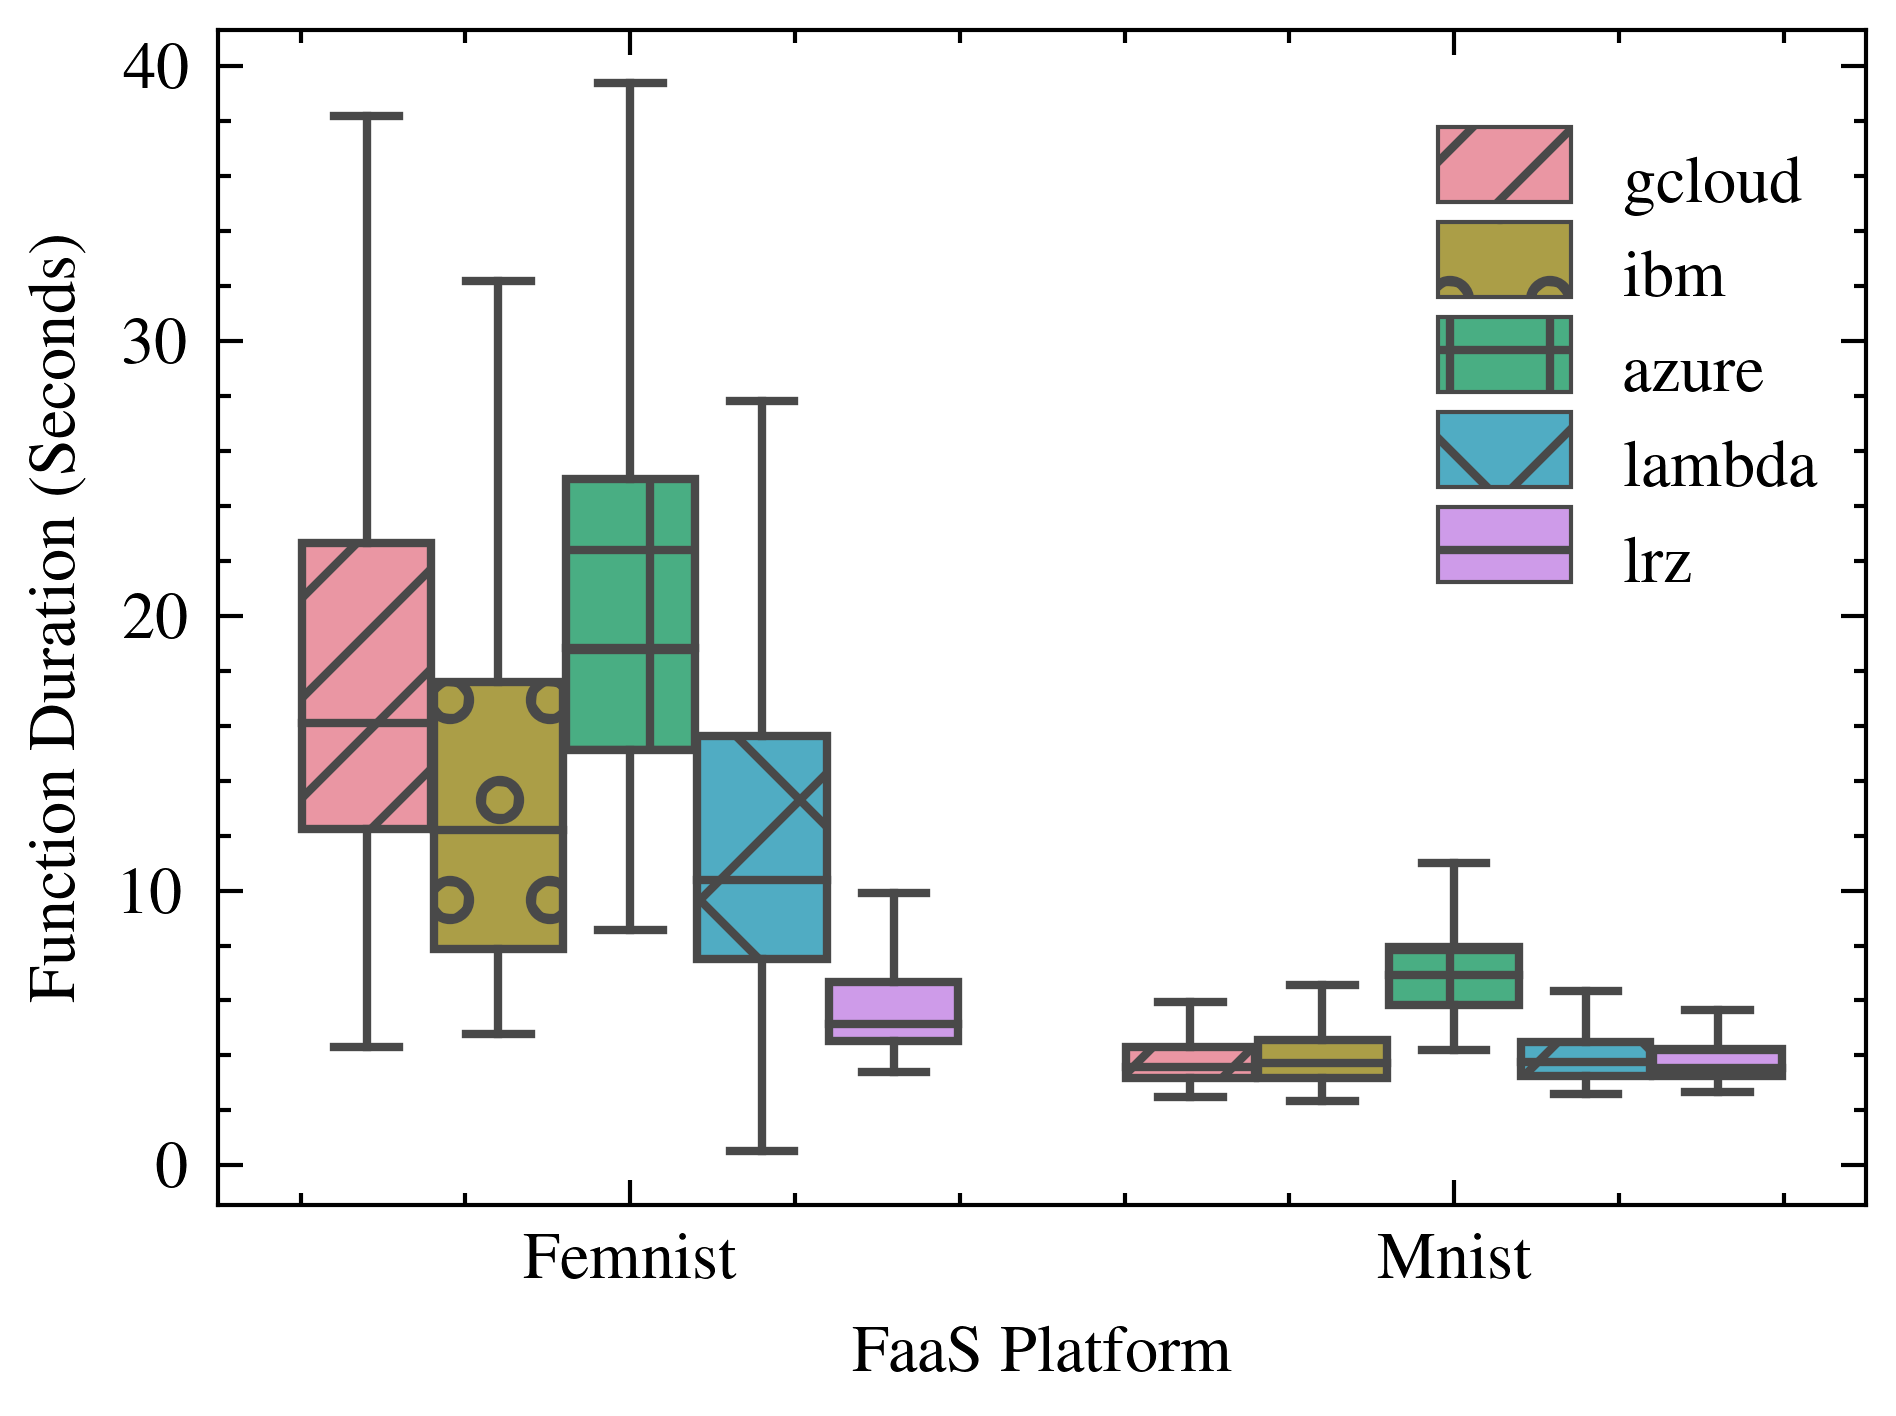

In [1064]:
plt.clf()
fig, ax = plt.subplots() # nrows=2, ncols=3, sharex="col", figsize=(7.167, 7.167 / 2))

df_ = fedless_clients_df.reset_index()
df_ = df_[df_["clients-total"] == 200]
df_ = df_[df_["eval"] == False]
df_ = df_[df_["dataset"] != "shakespeare"]
df_["dataset"] = df_["dataset"].apply(str.capitalize)

sns.boxplot(
    x="dataset",
    y="seconds",
    hue="platform",
    data=df_,
    showfliers=False, # Mention in text that removed
    ax=ax
)

hatches = itertools.cycle(['//', 'o', '+', 'x', '-', '.', 'x', '\\', '', '', 'O', '.'][:5]) # ['.', '//', '+', '-', 'x', '\\', '', 'o', 'O', '.'])
for i, patch in enumerate(ax.artists + ax.patches):
    hatch = next(hatches)
    patch.set_hatch(hatch)
#    patch.set_height(22)

ax.get_legend().remove()
leg = fig.legend(loc=(0.744, 0.56))
for patch in leg.get_patches():
    patch.set_height(9)

    
ax.set_xlabel("FaaS Platform")
ax.set_ylabel("Function Duration (Seconds)")
fig.tight_layout()
fig.savefig(PLOT_OUTPUT_DIR / f"fedless-platforms-durations.pdf", bbox_inches ='tight', pad_inches=0)

## MNIST with Privacy

Text(0, 0.5, 'Round Duration (Seconds)')

<Figure size 1980x1500 with 0 Axes>

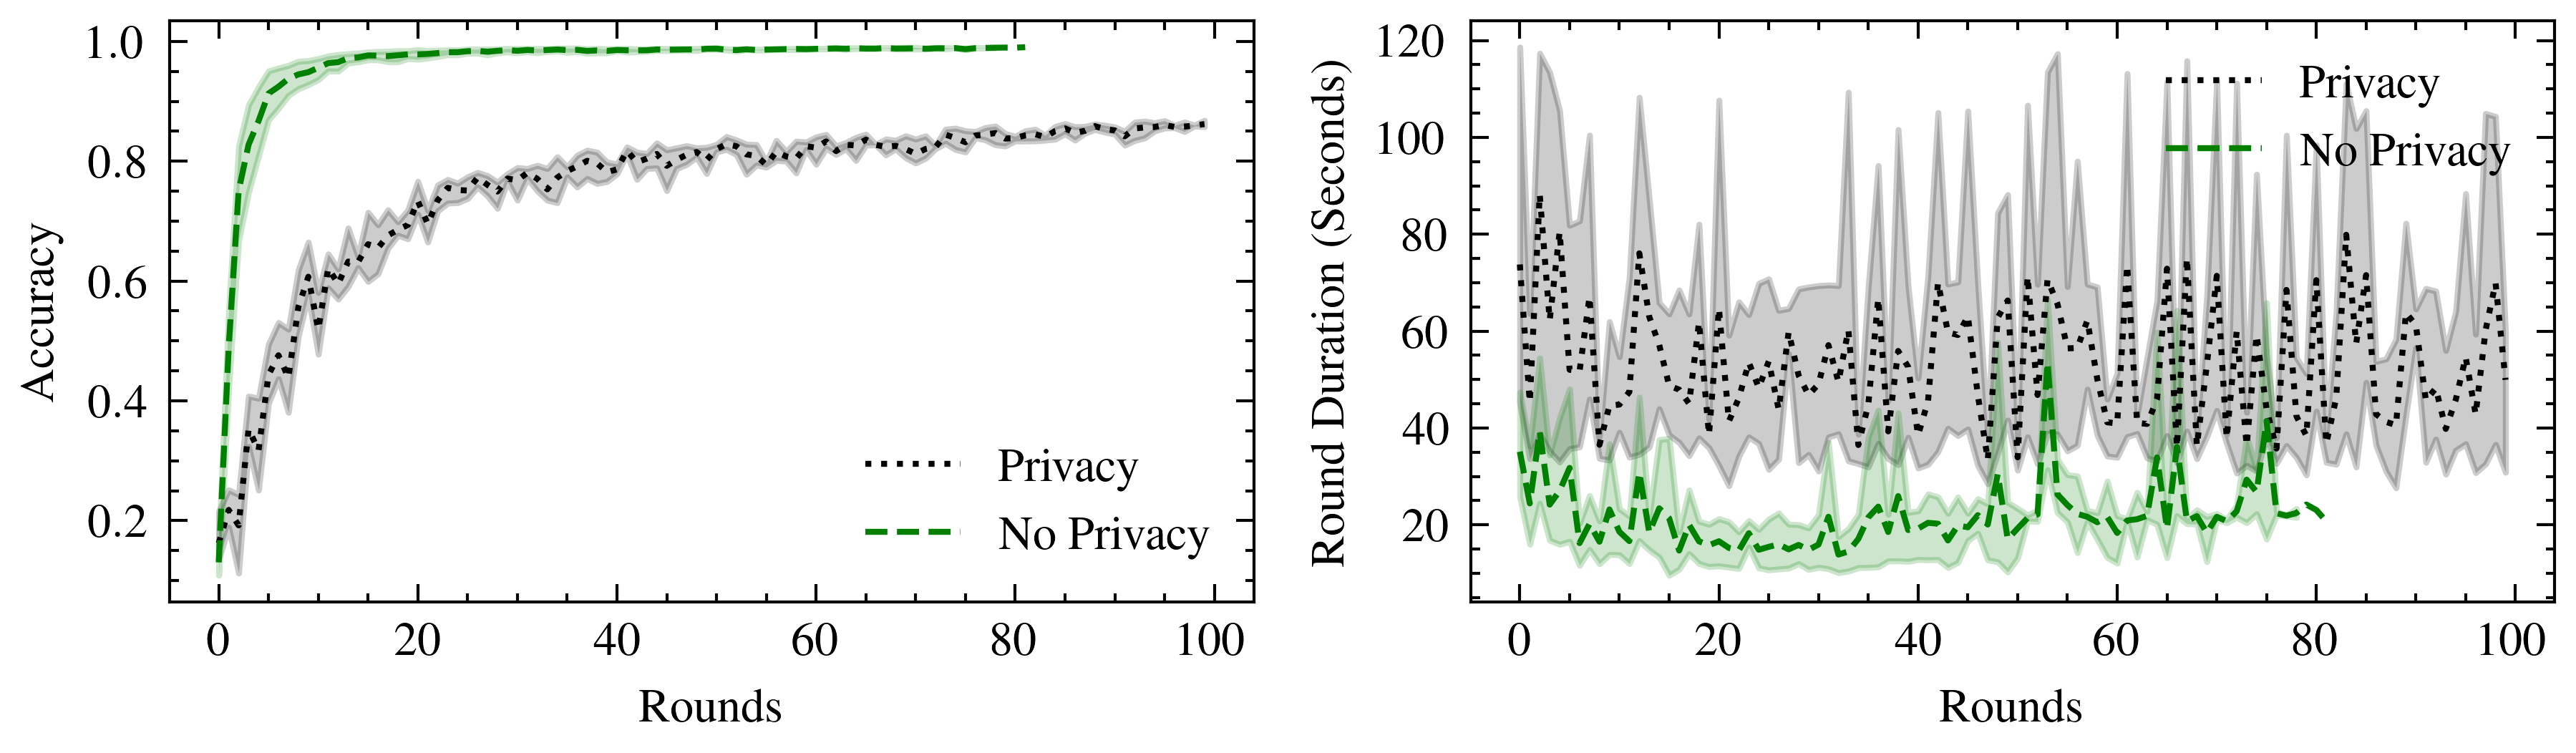

In [1071]:
plt.clf()

fig, axarr = plt.subplots(ncols=2, figsize=(7.167, 7.167 / 4), sharex=True)

sns.lineplot(x="round", y="accuracy", data=fedless_dp_df.loc[("mnist", 25), :], ax=axarr[0], label="Privacy")
sns.lineplot(x="round", y="accuracy", data=fedless_df.loc[("mnist", 25), :], ax=axarr[0], label="No Privacy")

sns.lineplot(x="round", y="time", data=fedless_dp_df.loc[("mnist", 25), :], ax=axarr[1], label="Privacy")
sns.lineplot(x="round", y="time", data=fedless_df.loc[("mnist", 25), :], ax=axarr[1], label="No Privacy")

axarr[0].set_xlabel("Rounds")
axarr[1].set_xlabel("Rounds")

axarr[0].set_ylabel("Accuracy")
axarr[1].set_ylabel("Round Duration (Seconds)")

## FedKeeper vs FedLess

FedLess: 4.5466+-1.24303939025048ms
FedKeeper (Optimized): 3.914878787878788+-0.27050925683771787ms
FedKeeper (Vanilla): 5.6882666666666655+-2.769687141577948ms


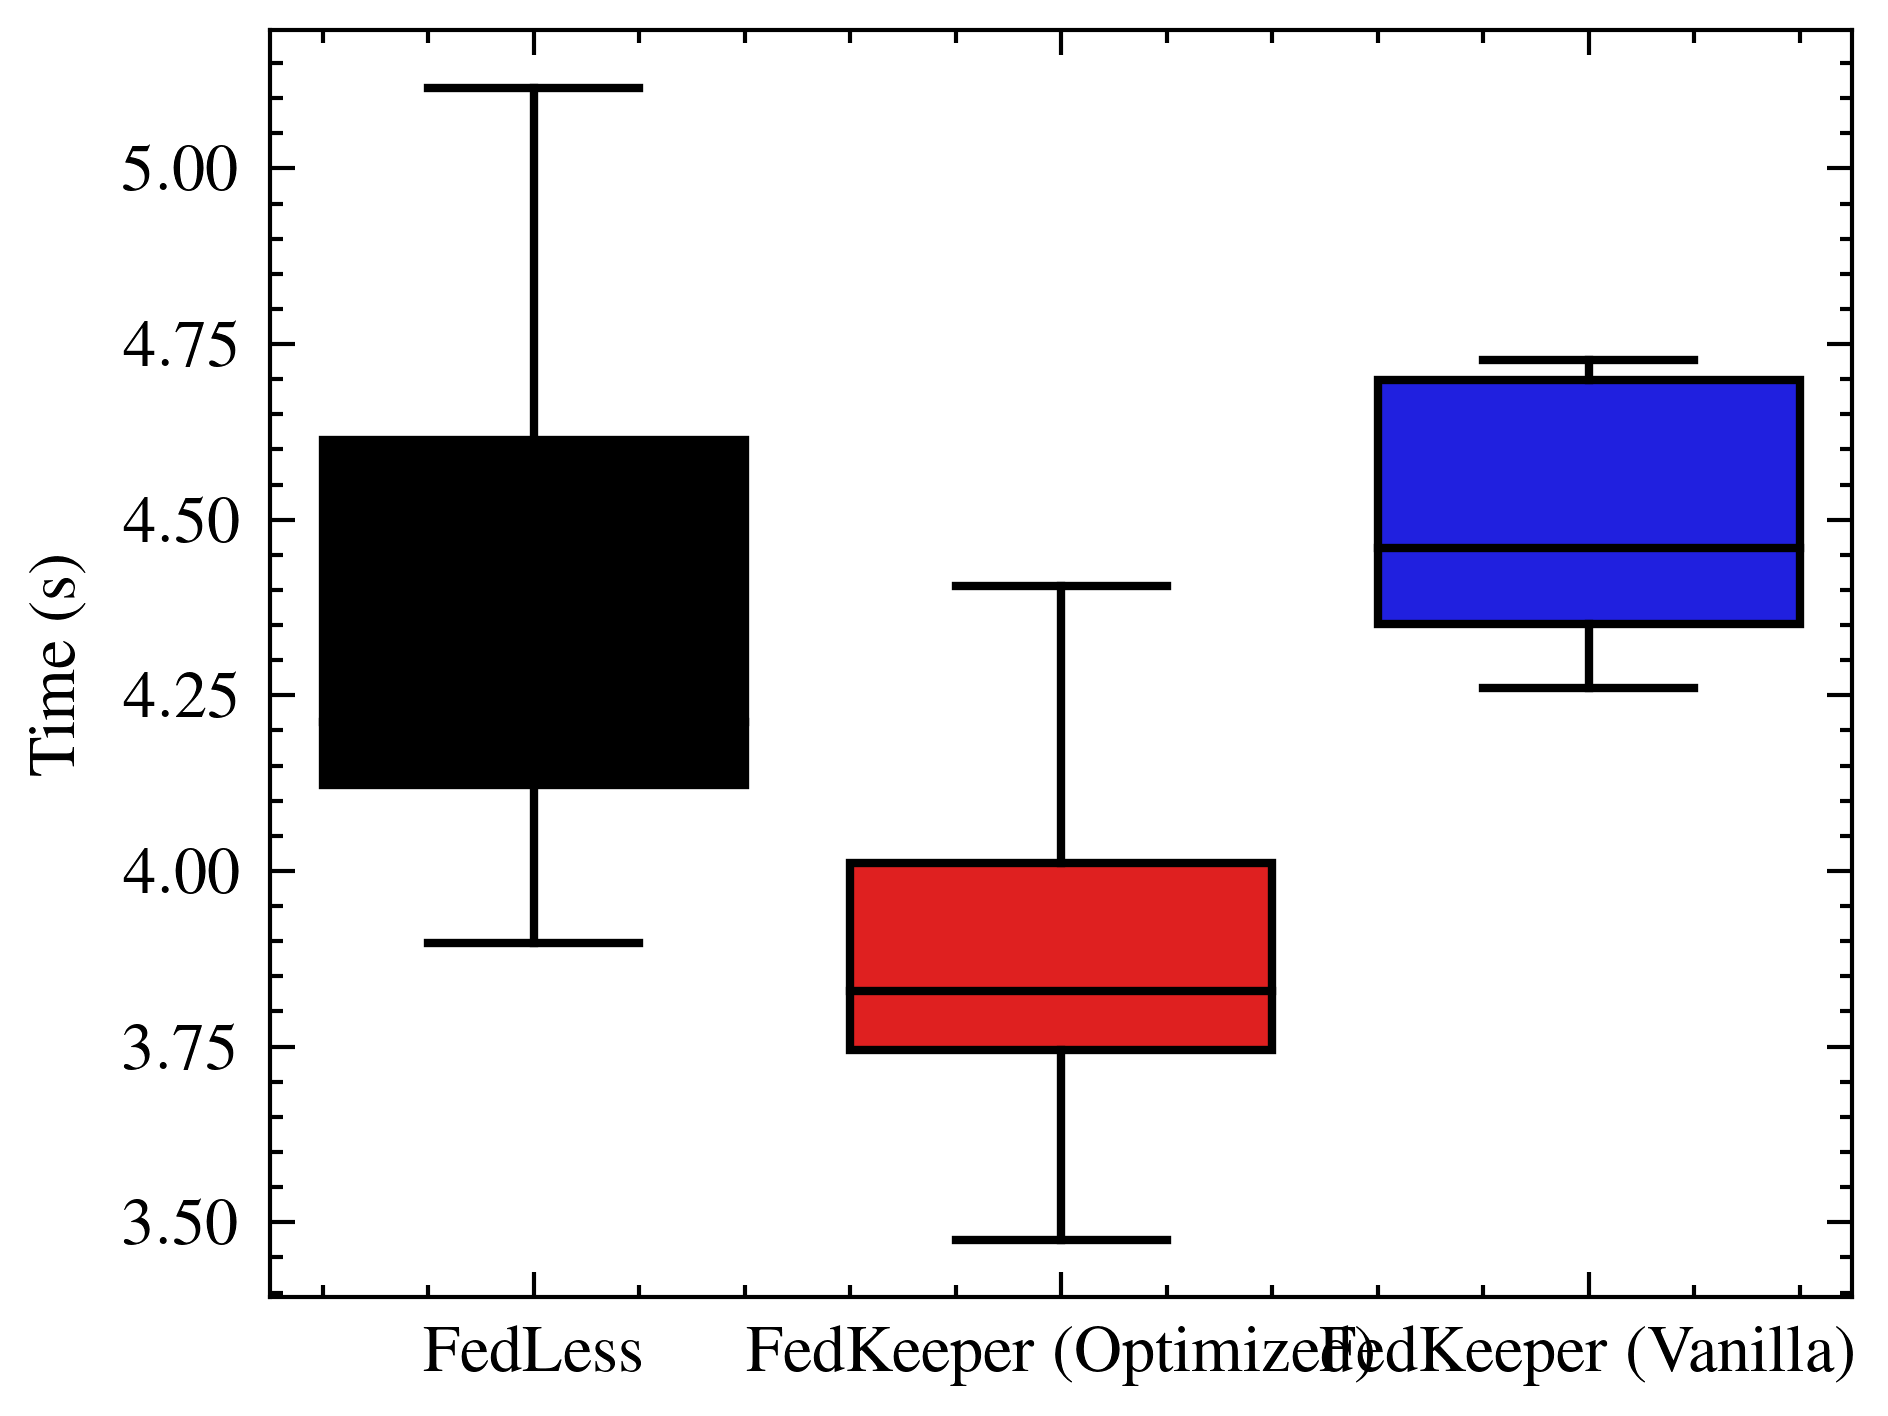

In [1072]:
fedkeeper_gcloud_client_1_log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181515-http-1.csv")
fedless_gcloud_client_1_log_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210805-181149-client-indep-1.csv")
fedkeeper_uncached_gcloud_clientlog_df = pd.read_csv(ROOT_OUT_DIR / "fedkeeper-fedless-gcloud-logs/downloaded-logs-20210806-152324-client-no-caching.csv")


# GCloud Client Functions runtime based on >30 rounds of 1 client each with same hyperparameters
vals = []
for method, df in [("FedLess", fedless_gcloud_client_1_log_df), ("FedKeeper (Optimized)", fedkeeper_gcloud_client_1_log_df), ("FedKeeper (Vanilla)", fedkeeper_uncached_gcloud_clientlog_df)]:
    log_statements  = df[df['textPayload'].astype(str).str.contains("Function execution took ")].textPayload
    timings = np.array([float(line[len("Function execution took "):].split(' ')[0]) for line in log_statements]) / 1000
    vals.append((method, timings))
    print(f"{method}: {timings.mean()}+-{timings.std()}ms")

df = pd.concat([pd.Series(timings) for _, timings in vals], keys=[m for m, _ in vals], names=["method"]).to_frame().reset_index()
fig, ax = plt.subplots()
sns.boxplot(x="method", y=0, data=df, ax=ax, showfliers=False) # showfliers=False => WARM STARTS 
ax.set_xlabel("")
ax.set_ylabel("Time (s)")
fig.tight_layout()

fedkeeper_optimization_mean_difference = (df[df["method"] == "fedkeeper (vanilla)"].mean() - df[df["method"] == "fedkeeper (optimized)"].mean())[0]

<AxesSubplot:xlabel='round', ylabel='accuracy'>

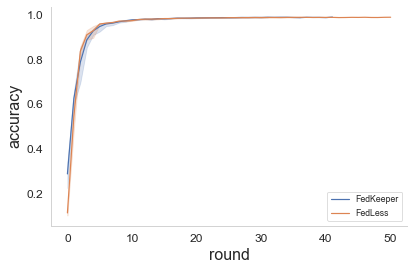

In [5]:
fedless_df_ = fedless_df.loc[("mnist", slice(1, 100), 100),:] # FedKeeper experiments
fedless_client_df_ = fedless_client_df.loc[("mnist", slice(1, 100), 100),:] # FedKeeper experiments


sns.lineplot(y="accuracy", x="round", data=fedkeeper_df.loc[("mnist", 25, 100),:], label="FedKeeper", )#, color="red")
sns.lineplot(y="accuracy", x="round", data=fedless_df_.loc[("mnist", 25, 100),:], label="FedLess", )# , color="blue")

In [927]:
fedkeeper_unoptimized = fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index().copy()
#fedkeeper_unoptimized["time"] += fedkeeper_optimization_mean_difference
fl_fk_comp_df = pd.concat([
    fedkeeper_df.loc[("mnist", slice(1, 75), 100),:].reset_index(),
#    fedkeeper_unoptimized,
    fedless_df_.loc[("mnist", slice(1, 75), 100),:].reset_index()
], keys=["FedKeeper", "FedLess"], names=["method"]).reset_index()
#], keys=["FedKeeper (optimized)", "FedKeeper (vanilla)", "FedLess"], names=["method"]).reset_index()
fl_fk_comp_df['cumsum'] = fl_fk_comp_df.groupby(["method", "clients-round", "seed"])['time'].transform(pd.Series.cumsum)

time                      
                              mean     median        std
method    clients-round                                 
FedKeeper 25             18.383194  12.048295   9.612048
          50             17.857385  13.123293  11.560761
          75             18.962259  15.309069  12.238020
FedLess   25             12.341028   9.753099   4.578256
          50             12.832891  10.884840   4.215781
          75             13.999582  12.297168   3.867614

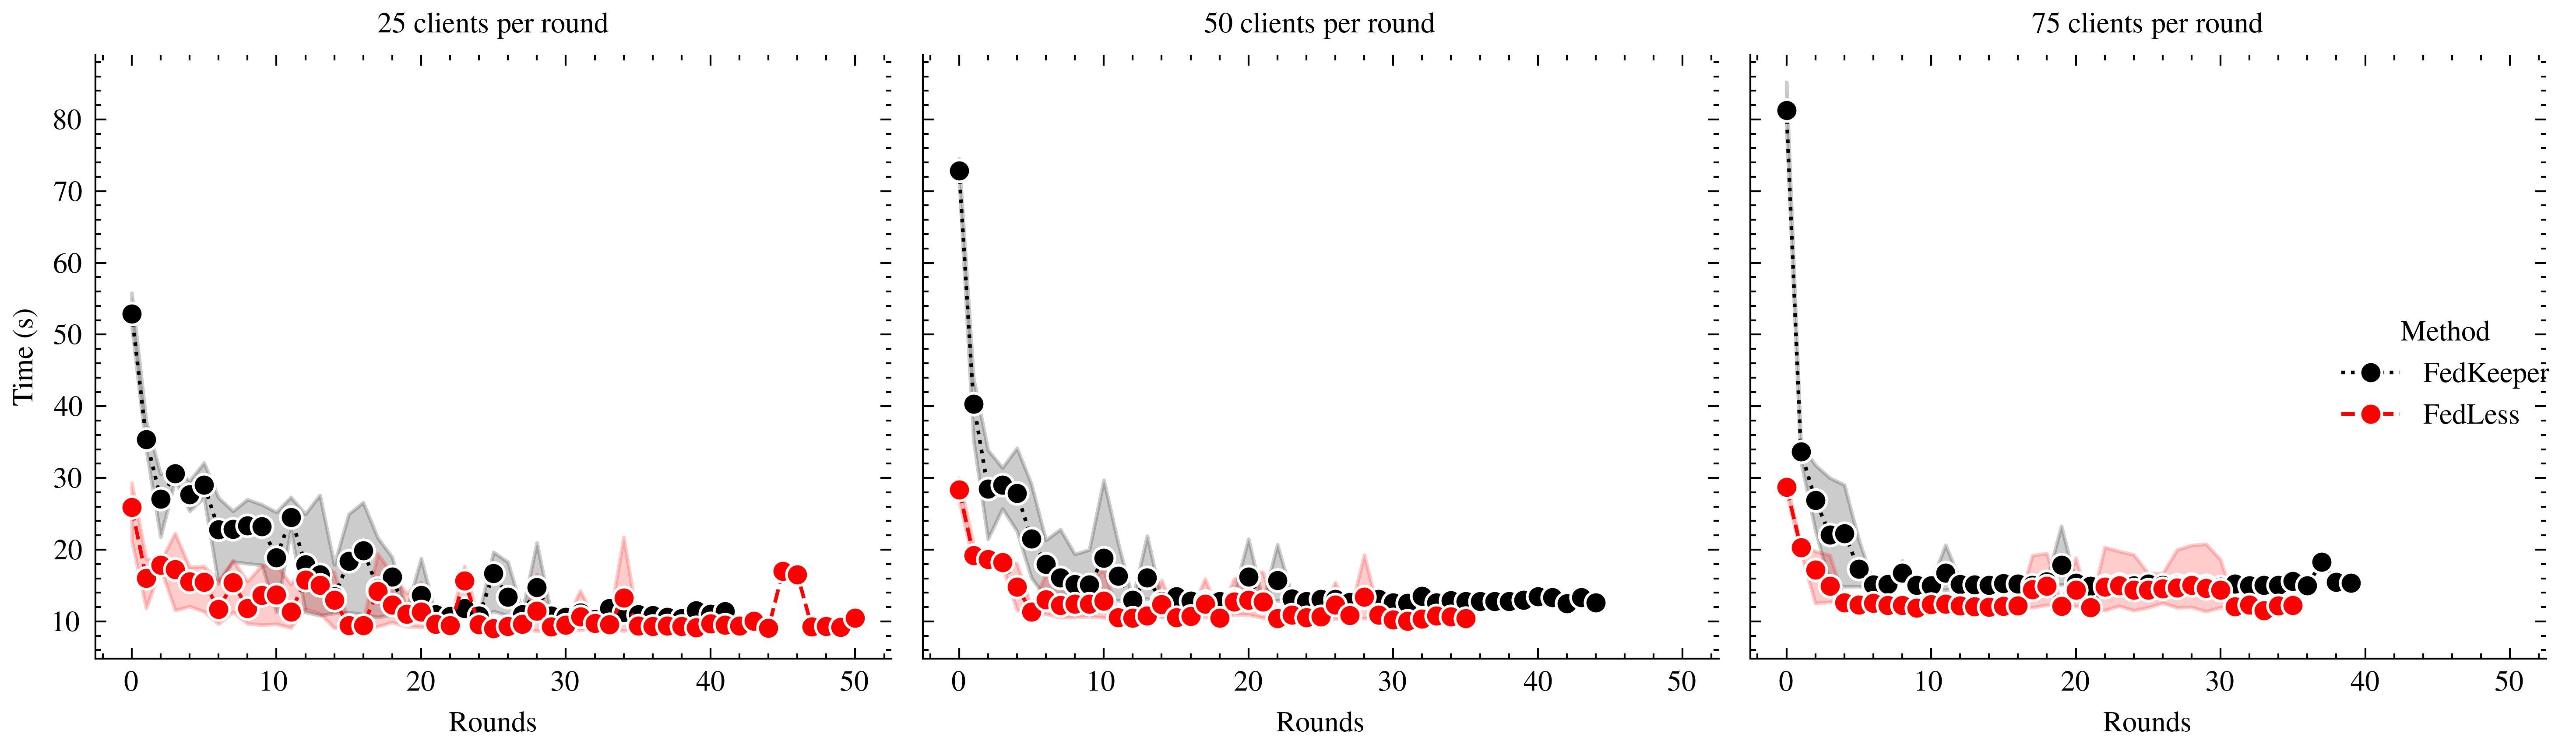

In [931]:
#sns.set_theme(style="ticks")
#sns.set_style("whitegrid")
grid = sns.FacetGrid(fl_fk_comp_df, col="clients-round",hue="method")#, hue_kws={"ls" : ["-","-.",":"]})
grid.map(sns.lineplot, "round", "time", marker="o")
grid.set_axis_labels("Rounds", "Time (s)")
grid.set_titles(col_template="{col_name} clients per round")# , row_template="{row_name}")
grid.add_legend()
grid.fig.tight_layout()
grid._legend.set_title("Method")
filename = "fedkeeper-fedless-timings.pdf"
os.remove(filename) if os.path.exists(filename) else None
grid.savefig(filename)#, overwrite=True)
fl_fk_comp_df.groupby(["method", "clients-round"]).agg({'time': [np.mean, np.median, np.std]})

In [99]:
def mean_std(vals):
    return f"{np.mean(vals).round(1)}$\pm${np.std(vals).round(1)}"
df_ = fl_fk_comp_df.groupby(["method", "clients_in_round"]).agg({'time': [mean_std]})#[np.mean, np.median, np.std]}).T.round(1)
df_.columns = ["time"]
#print(df_.to_latex())
print(df_.reset_index().pivot(index="clients_in_round", columns="method").to_latex())

\begin{tabular}{lll}
\toprule
{} & \multicolumn{2}{l}{time} \\
method &      FedKeeper &       FedLess \\
clients\_in\_round &                &               \\
\midrule
25               &   18.4\$\textbackslash pm\$9.6 &  12.3\$\textbackslash pm\$4.6 \\
50               &  17.9\$\textbackslash pm\$11.5 &  12.8\$\textbackslash pm\$4.2 \\
75               &  19.0\$\textbackslash pm\$12.2 &  14.0\$\textbackslash pm\$3.8 \\
\bottomrule
\end{tabular}



## Flower vs FedLess

NameError: name 'flower_df' is not defined

<Figure size 1980x1500 with 0 Axes>

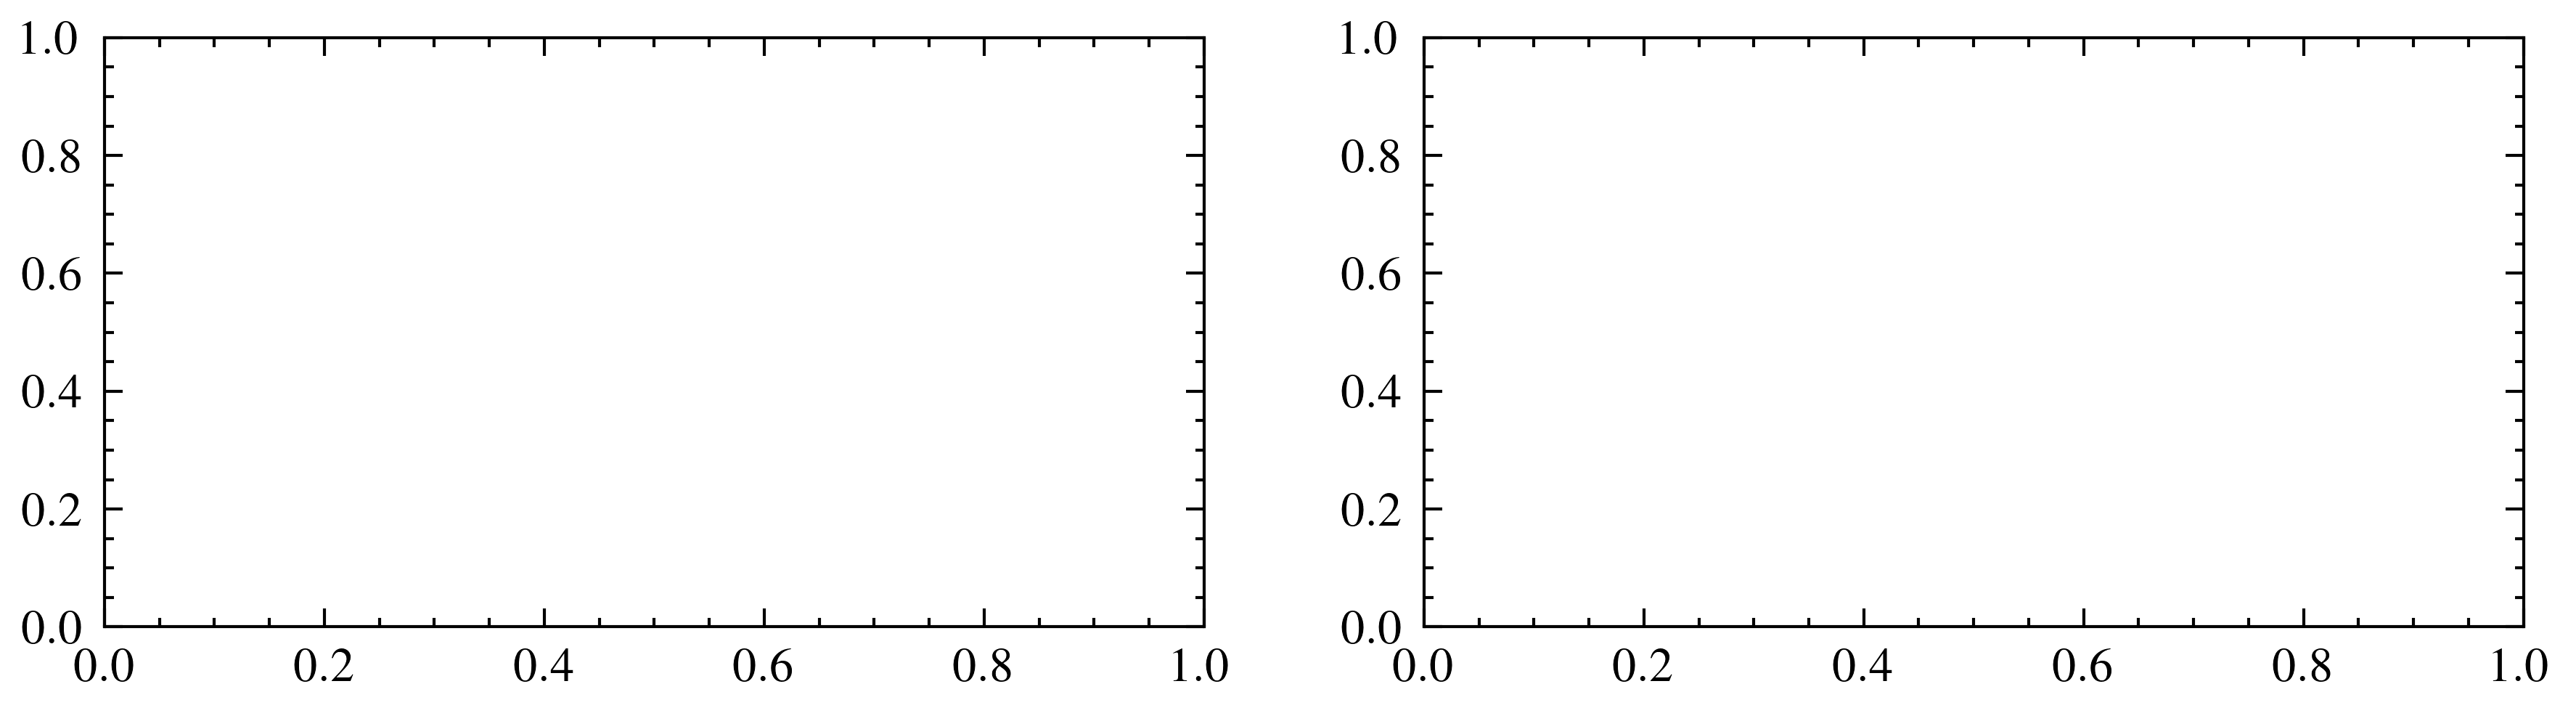

In [6]:
plt.clf()

fig, axarr = plt.subplots(ncols=2, figsize=(7.167, 7.167 / 4), sharex=True)

flower_fedless_df = pd.concat([
        flower_df.loc[("mnist", slice(1, 100), 100, 5, 10), :].reset_index(),
        fedless_df.loc[("mnist", slice(1, 100), 100, 5, 10, 1), :].reset_index()
    ],
    keys=["Flower", "FedLess"],
    names=["Method"]
)
flower_fedless_df

In [ ]:
# Pricing
from plot_utils import GCLOUD_FUNCTION_TIERS, calc_gcloud_function_cost, calc_lambda_function_cost
from fedless.benchmark.fedkeeper import create_mnist_cnn
from fedless.serialization import NpzWeightsSerializer


model_size = sys.getsizeof(NpzWeightsSerializer().serialize(create_mnist_cnn().get_weights())) / 10**6
memory, cpu_ghz, _ = 2048, 2.4, 2.9e-06
gcloud_cost = calc_gcloud_function_cost(
                        memory=memory, 
                        cpu_ghz=cpu_ghz,
                        invocations=7259,
                        function_runtime_seconds=3.281925,
                        function_egress_mb=model_size,
                        substract_free_tier=False)
lambda_cost = calc_lambda_function_cost(
    memory=2048,
    invocations=7259.000000,
    function_runtime_seconds=3.301694,
    function_egress_mb=model_size,
    num_active_instances=170,
    substract_free_tier=False)

sns.barplot(x=["gcloud", "lambda"], y=[gcloud_cost, lambda_cost])